## 0. Install and Import Dependencies

In [77]:
!pip install easyocr
!pip install imutils


[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [78]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import imutils
import easyocr

## 1. Read in Image, Grayscale and Blur

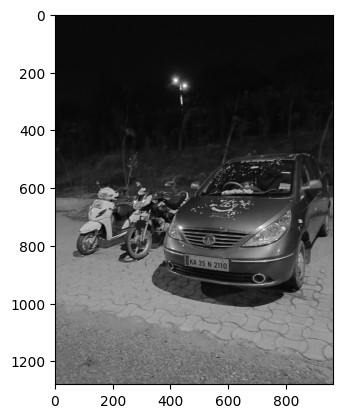

In [91]:
img = cv2.imread('D:\mini project.1\ANPRwithPython-main\WhatsApp Image 2024-08-13 at 19.54.33_e866005a.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))

## 2. Apply filter and find edges for localization

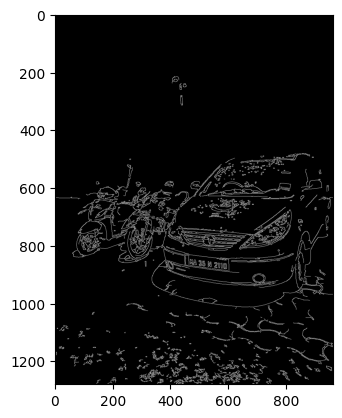

In [92]:
bfilter = cv2.bilateralFilter(gray, 11, 17, 17) #Noise reduction
edged = cv2.Canny(bfilter, 30, 200) #Edge detection
plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB))

## 3. Find Contours and Apply Mask

In [93]:
keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(keypoints)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

In [98]:
location = None
for contour in contours:
    approx = cv2.approxPolyDP(contour, 10, True)
    if len(approx) == 4:
        location = approx
        break

In [99]:
location

array([[[447, 832]],

       [[598, 848]],

       [[600, 889]],

       [[451, 871]]], dtype=int32)

In [100]:
mask = np.zeros(gray.shape, np.uint8)
new_image = cv2.drawContours(mask, [location], 0,255, -1)
new_image = cv2.bitwise_and(img, img, mask=mask)

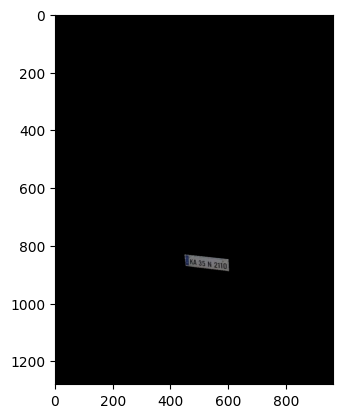

In [101]:
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))

In [102]:
(x,y) = np.where(mask==255)
(x1, y1) = (np.min(x), np.min(y))
(x2, y2) = (np.max(x), np.max(y))
cropped_image = gray[x1:x2+1, y1:y2+1]

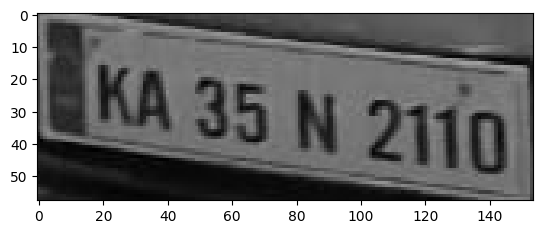

In [103]:
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))

## 4. Use Easy OCR To Read Text

In [104]:
reader = easyocr.Reader(['en'])
result = reader.readtext(cropped_image)
result

[([[12, 8], [154, 8], [154, 58], [12, 58]],
  'KA 35 N 2110]',
  0.8213093067010708)]

## 5. Render Result

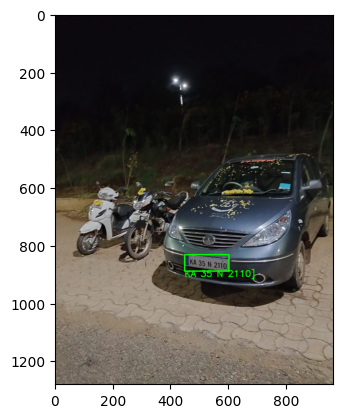

In [105]:
text = result[0][-2]
font = cv2.FONT_HERSHEY_SIMPLEX
res = cv2.putText(img, text=text, org=(approx[0][0][0], approx[1][0][1]+60), fontFace=font, fontScale=1, color=(0,255,0), thickness=2, lineType=cv2.LINE_AA)
res = cv2.rectangle(img, tuple(approx[0][0]), tuple(approx[2][0]), (0,255,0),3)
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))

In [107]:
extract_ = result[0][1]
RTO= extract_.replace(" ", "").replace(".", "").replace("]","")  
print(RTO)    

KA35N2110


In [108]:
import requests
import json
from tabulate import tabulate

url = "https://rto-vehicle-information-verification-india.p.rapidapi.com/api/v1/rc/vehicleinfo"

payload = {
	"reg_no": RTO,
	"consent": "Y",
	"consent_text": "I hear by declare my consent agreement for fetching my information via AITAN Labs API"
}
headers = {
	"x-rapidapi-key": "fbf66e6284mshe729eb6ed842ceap1bdad2jsna77784319e46",
	"x-rapidapi-host": "rto-vehicle-information-verification-india.p.rapidapi.com",
	"Content-Type": "application/json"
}

response = requests.post(url, json=payload, headers=headers)

user_data = response.json()


In [110]:
def flatten_json(nested_json, parent_key='', sep='_'):
    """
    Flatten a nested JSON object.

    :param nested_json: The nested JSON object to flatten.
    :param parent_key: The base key string to prepend to the keys.
    :param sep: The separator between parent and child keys.
    :return: A flattened dictionary.
    """
    flattened_dict = {}

    for key, value in nested_json.items():
        new_key = f"{parent_key}{sep}{key}" if parent_key else key

        if isinstance(value, dict):
            # Recursively flatten the dictionary
            flattened_dict.update(flatten_json(value, new_key, sep=sep))
        elif isinstance(value, list):
            # Handle lists by flattening each item
            for i, item in enumerate(value):
                flattened_dict.update(flatten_json({f"{new_key}_{i}": item}, sep=sep))
        else:
            flattened_dict[new_key] = value

    return flattened_dict

In [111]:
flattened_json = flatten_json(user_data)
table = [[key, value] for key, value in flattened_json.items()]
print(tabulate(table, headers=["Key", "Value"], tablefmt="grid", stralign="left"))

+---------------------------------------------------------+-------------------------------------------------------------------------------+
| Key                                                     | Value                                                                         |
+=========================================================+===============================================================================+
| status                                                  | success                                                                       |
+---------------------------------------------------------+-------------------------------------------------------------------------------+
| message                                                 | Vehicle Found                                                                 |
+---------------------------------------------------------+-------------------------------------------------------------------------------+
| response_type     